# SVM으로 얼굴 사진 분류하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2021)

# 1. Data

1.1 Data Load

데이터는 sklearn.datasets의 fech_lfw_people로 받을 수 있습니다.

In [2]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [5]:
# data, target 각각 저장
data, target = faces["data"], faces["target"]

1.2 Data EDA

이미지의 height와 width를 확인항면 다음과 같음

In [6]:
n_samples, h, w = faces.images.shape

In [7]:
n_samples, h, w

(1288, 50, 37)

In [11]:
target_names = faces.target_names #?
n_classes = target_names.shape[0] #?

In [12]:
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

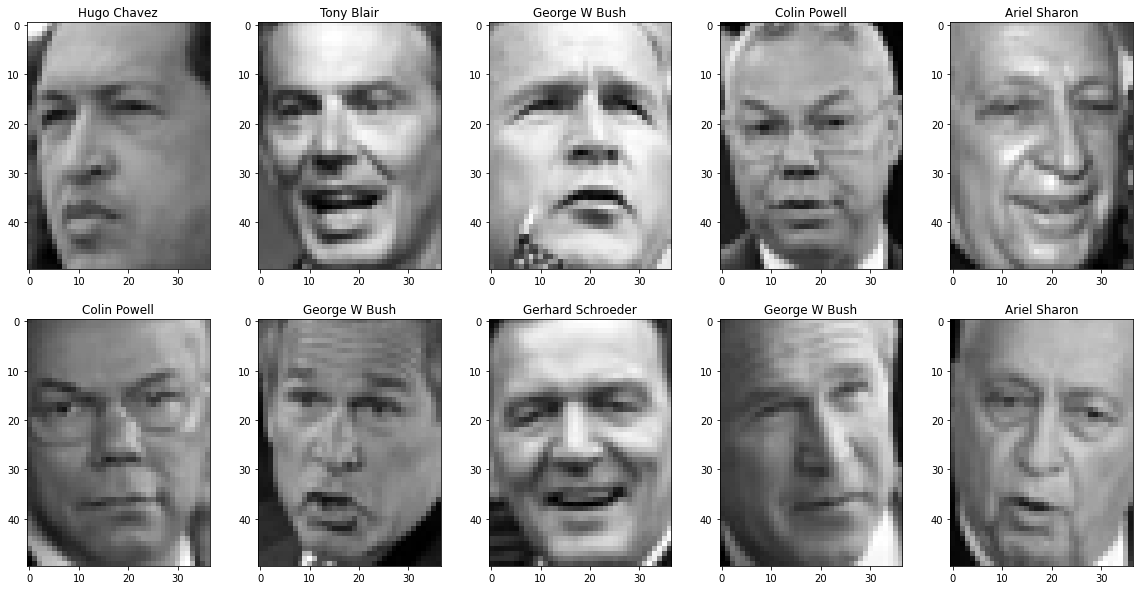

In [14]:
# 이미지 실제 확인하기
samples = data[:10].reshape(10,h,w) #?
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
for idx, sample in enumerate(samples): #?
  ax = axes[idx//5, idx%5]
  ax.imshow(sample, cmap="gray")
  ax.set_title(target_names[target[idx]])

# 1.3 Data Split

In [15]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(
    data, target, train_size=0.7, random_state=2021
)

In [16]:
print(f"train_data size: {len(train_target)}, {len(train_target)/len(data):.2f}")
print(f"test_data size: {len(test_target)}, {len(test_target)/len(data):.2f}")

train_data size: 901, 0.70
test_data size: 387, 0.30


# 1.4 Data Scaling

SVM 역시 거리를 기반으로 모델을 학습하기 때문에 데이터의 범위를 줄여주어야 함

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [18]:
# scaler 통해서 범위 줄여줌
scaler.fit(train_data)  

StandardScaler()

In [20]:
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

# 2. SVM

2.1 Baseline

In [21]:
from sklearn.svm import SVC

svm = SVC()

In [31]:
svm.fit(scaled_train_data, train_target)

SVC()

In [32]:
train_pred = svm.predict(scaled_train_data)
test_pred = svm.predict(scaled_test_data)

In [28]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(train_target, train_pred)
test_acc = accuracy_score(test_target, test_pred)

In [34]:
print(f"train accuracy is {train_acc:.4f}")
print(f"test accuracy is {test_acc:.4f}") # train data 오버피팅 발생

train accuracy is 0.9501
test accuracy is 0.7209


# 2.2 Hyper Parameter Tuning

In [35]:
from sklearn.model_selection import GridSearchCV

2.2.1 탐색 범위 설정

In [40]:
# dictionary for loop을 돌림
# linear인 경우와, rbf인 경우 C의 허용범위가 달라서 따로 해줘야함
params = [
    {"kernel":["linear"], "C":[10,30,100,300,1000,3000,10000,30000]},
    {
        "kernel":["rbf"],
        "C":[1,3,10,30,100,300,1000],
        "gamma":[0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
    },
]

In [37]:
params

[{'kernel': ['linear'], 'C': [10, 30, 100, 300, 1000, 3000, 10000, 30000]},
 {'kernel': ['rbf'],
  'C': [1, 3, 10, 30, 100, 300, 1000],
  'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}]

2.2.2 탐색

In [39]:
grid_cv = GridSearchCV(svm, params, cv=3, n_jobs=-1)
grid_cv.fit(scaled_train_data, train_target)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [10, 30, 100, 300, 1000, 3000, 10000, 30000],
                          'kernel': ['linear']},
                         {'C': [1, 3, 10, 30, 100, 300, 1000],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}])

2.2.3 결과

In [41]:
print(f"Best score of parameter search is: {grid_cv.best_score_:.4f}")

Best score of parameter search is: 0.8080


In [42]:
print("Best parameter of best score is")
for key, value in grid_cv.best_params_.items():
  print(f"\t {key}: {value}")

Best parameter of best score is
	 C: 10
	 kernel: linear


In [45]:
# 가장 성능이 좋았떤 svm을 이용해서 예측
train_pred = grid_cv.best_estimator_.predict(scaled_train_data)
test_pred = grid_cv.best_estimator_.predict(scaled_test_data)

In [47]:
best_train_acc = accuracy_score(train_target, train_pred)
best_test_acc = accuracy_score(test_target, test_pred)

In [48]:
print(f"Best Parameter train accuracy is {best_train_acc:.4f}")
print(f"Best parameter test accuracy is {best_test_acc:.4f}")

Best Parameter train accuracy is 1.0000
Best parameter test accuracy is 0.8682


# 3. 마무리

In [50]:
# SVM은 어떤 argument를 주느냐에 따라서 성능차이가 큼
# 튜닝을 최대한 많이하는게 좋음
print(f"Baseline test accuracy is {test_acc:.4f}")
print(f"Best parameter test accuracy is {best_test_acc:.4f}")

Baseline test accuracy is 0.7209
Best parameter test accuracy is 0.8682
